In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pywt
from tqdm import tqdm
from matplotlib.image import imread
import os

In [4]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

# File path to the EXR file
file_path = f"/Users/haithameleuch/Documents/Uni_Siegen/3_Semester_WS/Computational Imaging/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_17_r_0_g_1_b_0_cropped.exr"

# Open the EXR file
exr_file = OpenEXR.InputFile(file_path)

# Get the header and dimensions
header = exr_file.header()
dw = header['dataWindow']
width = dw.max.x - dw.min.x + 1
height = dw.max.y - dw.min.y + 1
print(f"Dimensions: {width}x{height}")

# Channels to extract
channels = ['R', 'G', 'B']
use_float16 = False

# Determine pixel type
pixel_type = Imath.PixelType(Imath.PixelType.HALF)

# Allocate memory and load channels
img = np.empty((height, width, len(channels)), dtype=np.float16)

for i, channel in enumerate(channels):
    raw_data = exr_file.channel(channel, pixel_type)
    img[:, :, i] = np.frombuffer(raw_data, dtype=np.float16).reshape(height, width)

# Verify the loaded data
print(f"Image shape: {img.shape}")

# Convert to float32 for processing
img_float32 = img.astype(np.float32)

# Function to adjust EV and gamma
def adjust_image(img, ev=0, gamma=2.2):
    """
    Adjusts the exposure and gamma of an HDR image.
    
    Parameters:
        img (np.ndarray): Input HDR image as a NumPy array.
        ev (float): Exposure value to adjust brightness. Positive increases, negative decreases.
        gamma (float): Gamma correction value.
    
    Returns:
        np.ndarray: Adjusted image.
    """
    # Apply exposure adjustment (2^EV)
    img_ev = img * (2 ** ev)
    
    # Apply gamma correction
    img_gamma = np.power(img_ev, 1 / gamma)
    
    # Normalize the image to [0, 1] for display
    img_normalized = np.clip(img_gamma, 0, 1)
    
    return img_normalized

# Set EV and gamma values
ev = 0.0  # Increase brightness (try values like -2.0, 0.0, 1.0, 2.0)
gamma = 2.2  # Gamma correction (try values like 1.8, 2.2, etc.)

# Adjust image
img_adjusted = adjust_image(img_float32, ev=ev, gamma=gamma)

# Plot the original and adjusted image
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(np.clip(img_float32, 0, 1))  # Clip original for visualization
plt.axis('off')
plt.title("Original EXR Image")

# Adjusted image
plt.subplot(1, 2, 2)
plt.imshow(img_adjusted)
plt.axis('off')
plt.title(f"Adjusted Image (EV={ev}, Gamma={gamma})")

plt.show()

/Users/haithameleuch/Documents/Uni_Siegen/3_Semester_WS/Computational Imaging/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_17_r_0_g_1_b_0_cropped.exr: (EXR_ERR_FILE_ACCESS) Unable to open file for read: No such file or directory


OSError: Unable to open '/Users/haithameleuch/Documents/Uni_Siegen/3_Semester_WS/Computational Imaging/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_17_r_0_g_1_b_0_cropped.exr' for read

In [ ]:

# Define paths and parameters
file_path = "/home/arman/Documents/arman/Uni/Master/Semester 3/ip_repository/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_16_r_0_g_1_b_0_cropped.exr"
sigma_psd = 0.05  # Set a single sigma value to test
stage_arg = BM3DStages.HARD_THRESHOLDING  # Use one stage (e.g., HARD_THRESHOLDING)

# Load noisy image
noisy_img, _ = process_exr(file_path)

# Perform BM3D denoising with the selected sigma value
denoised_img = bm3d(noisy_img, sigma_psd=sigma_psd, profile="np", stage_arg=stage_arg)

# Calculate SNR for the denoised image
snr_denoised = calculate_snr((denoised_img * 255).astype("uint8"))  # Scale to 255 for SNR calculation

# Print the SNR value for the denoised image
print(f"SNR for Sigma PSD {sigma_psd:.3f}: {snr_denoised:.2f} dB")

# Plot the SNR value (though it is a single point, for clarity)
plt.imshow(denoised_img)

# Show the plot in the notebook
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Function to calculate PSNR
def calculate_psnr(original, denoised):
    mse = mean_squared_error(original, denoised)
    return 20 * np.log10(1 / np.sqrt(mse)) if mse > 0 else float('inf')

# Wavelet denoising function using skimage's denoise_wavelet
def wavelet_denoise(image, wavelet, method):
    denoised_image = restoration.denoise_wavelet(image, wavelet=wavelet,
                                                 mode="soft", method=method, 
                                                 wavelet_levels=None,
                                                 rescale_sigma=True)
    return denoised_image

# Expanded Parameter grid
param_grid = {
    "wavelet": ["db1", "db2", "db3", "sym2", "sym3"],
    "method": ["BayesShrink", "VisuShrink"],
}

# Grid search
best_params = None
#best_psnr = -np.inf
sigma = 0.05

# Example noisy image and original image (assuming image_array is predefined)
# noisy_image = image_array + sigma * np.random.normal(size=image_array.shape)
noisy_image = img_adjusted.copy()

# List to store PSNR values and corresponding parameters
#psnr_list = []

# Loop through the parameter grid
for wavelet in param_grid["wavelet"]:
    for method in param_grid["method"]:
        # Denoise the image using wavelet denoising from skimage
        denoised_image = wavelet_denoise(noisy_image, wavelet, method)
        
        # Calculate PSNR
        #psnr = calculate_psnr(noisy_image, denoised_image)

        # Store PSNR with the corresponding parameters and denoised image
        # psnr_list.append({
        #     "psnr": psnr,
        #     "wavelet": wavelet,
        #     "method": method,
        #     "denoised_image": denoised_image
        # })

# Sort the list by PSNR in descending order and get the top 10
#top_10_psnrs = sorted(psnr_list, key=lambda x: x["psnr"], reverse=True)[:10]

# Create subplots, with rows for wavelets and columns for methods
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 18))
axes = axes.flatten()

# Organize the top 10 results by wavelet and method
for idx, result in enumerate(top_10_psnrs):
    # Get the denoised image, PSNR, wavelet, and method
    denoised_image = result['denoised_image']
    psnr = result['psnr']
    wavelet = result['wavelet']
    method = result['method']
    
    # Find the correct subplot position: each method gets a separate column
    row = param_grid["wavelet"].index(wavelet)  # row is determined by wavelet
    col = param_grid["method"].index(method)    # column is determined by method
    
    # Plot the denoised image in the correct position
    ax = axes[row * 2 + col]  # Calculate the correct axis position
    ax.imshow(denoised_image, cmap='gray')
    ax.axis('off')  # Hide axis

    # Add title with PSNR and parameters
    ax.set_title(f"PSNR: {psnr:.2f}\nWavelet: {wavelet}\nMethod: {method}", fontsize=8)

# Adjust layout to maximize image space
plt.tight_layout(pad=1.0)
plt.show()


ValueError: Found array with dim 3. None expected <= 2.

In [11]:
denoised_image = restoration.denoise_wavelet(noisy_image, wavelet="db1",
                                                 mode="hard", method="VisuShrink", 
                                                 wavelet_levels=None,
                                                 rescale_sigma=True)



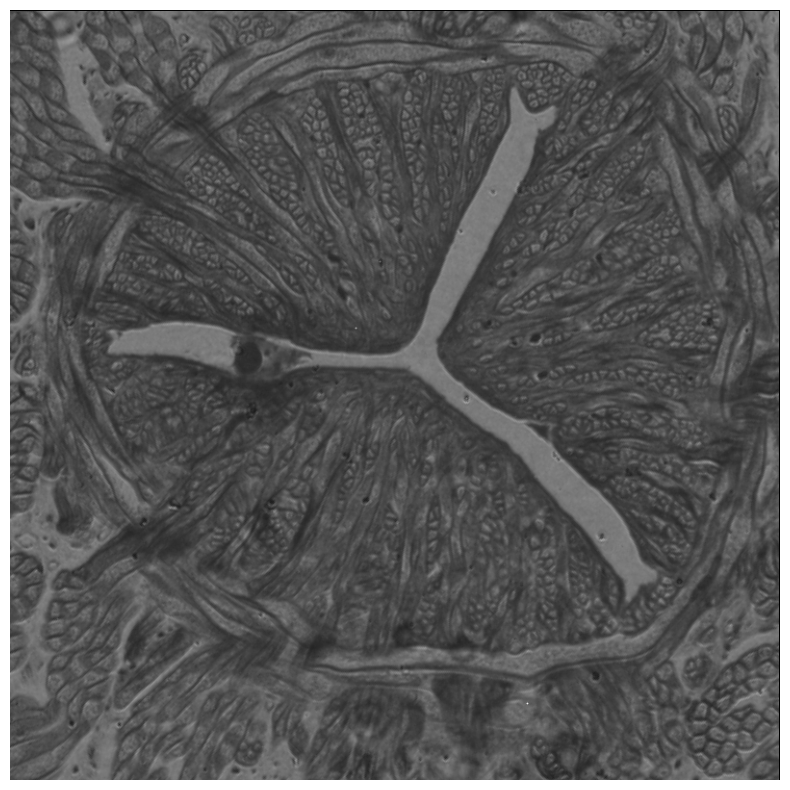

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(denoised_image, cmap='gray')
plt.axis('off')
plt.show()


TEST WITH WAVELET

Dimensions: 800x800
Image shape: (800, 800, 3)


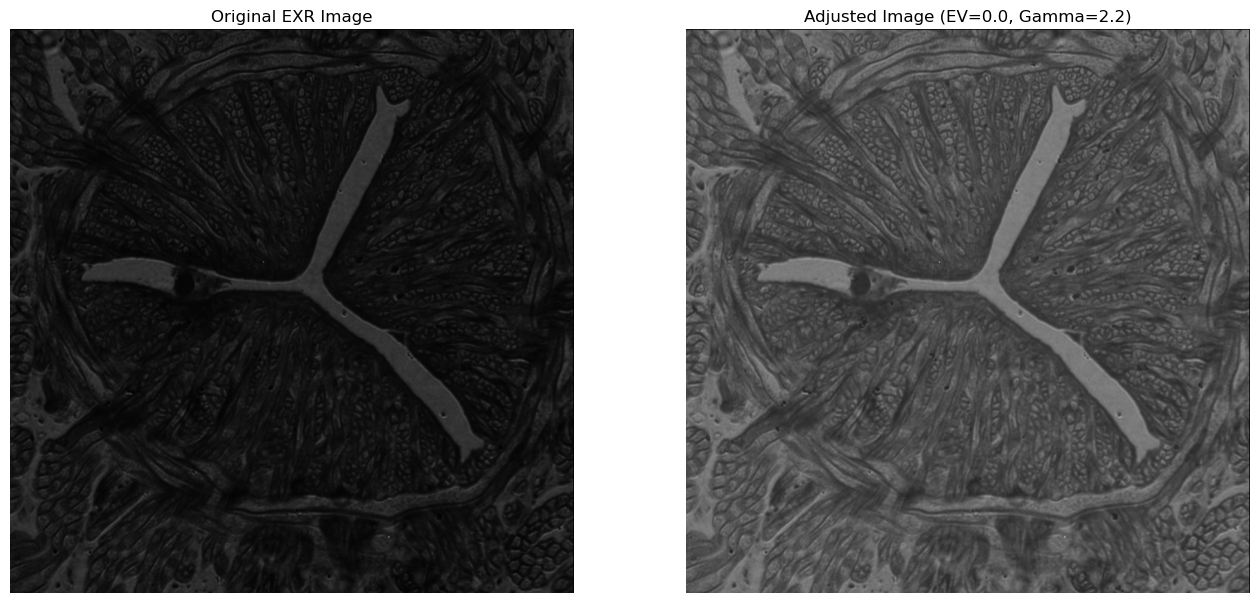

In [1]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

# File path to the EXR file
file_path = f"/Users/haithameleuch/Documents/Uni_Siegen/3_Semester_WS/Computational Imaging/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_17_r_0_g_1_b_0_cropped.exr"

# Open the EXR file
exr_file = OpenEXR.InputFile(file_path)

# Get the header and dimensions
header = exr_file.header()
dw = header['dataWindow']
width = dw.max.x - dw.min.x + 1
height = dw.max.y - dw.min.y + 1
print(f"Dimensions: {width}x{height}")

# Channels to extract
channels = ['R', 'G', 'B']
use_float16 = False

# Determine pixel type
pixel_type = Imath.PixelType(Imath.PixelType.HALF)

# Allocate memory and load channels
img = np.empty((height, width, len(channels)), dtype=np.float16)

for i, channel in enumerate(channels):
    raw_data = exr_file.channel(channel, pixel_type)
    img[:, :, i] = np.frombuffer(raw_data, dtype=np.float16).reshape(height, width)

# Verify the loaded data
print(f"Image shape: {img.shape}")

# Convert to float32 for processing
img_float32 = img.astype(np.float32)

# Function to adjust EV and gamma
def adjust_image(img, ev=0, gamma=2.2):
    """
    Adjusts the exposure and gamma of an HDR image.
    
    Parameters:
        img (np.ndarray): Input HDR image as a NumPy array.
        ev (float): Exposure value to adjust brightness. Positive increases, negative decreases.
        gamma (float): Gamma correction value.
    
    Returns:
        np.ndarray: Adjusted image.
    """
    # Apply exposure adjustment (2^EV)
    img_ev = img * (2 ** ev)
    
    # Apply gamma correction
    img_gamma = np.power(img_ev, 1 / gamma)
    
    # Normalize the image to [0, 1] for display
    img_normalized = np.clip(img_gamma, 0, 1)
    
    return img_normalized

# Set EV and gamma values
ev = 0.0  # Increase brightness (try values like -2.0, 0.0, 1.0, 2.0)
gamma = 2.2  # Gamma correction (try values like 1.8, 2.2, etc.)

# Adjust image
img_adjusted = adjust_image(img_float32, ev=ev, gamma=gamma)

# Plot the original and adjusted image
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(np.clip(img_float32, 0, 1))  # Clip original for visualization
plt.axis('off')
plt.title("Original EXR Image")

# Adjusted image
plt.subplot(1, 2, 2)
plt.imshow(img_adjusted)
plt.axis('off')
plt.title(f"Adjusted Image (EV={ev}, Gamma={gamma})")

plt.show()
